In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

main_folder = Path('.')

# Make an empty list to store dataframes
all_dataframes = []

# Loop through all subfolders within the main folder
for subfolder in main_folder.iterdir():
    if subfolder.is_dir():
        # Loop through all CSV files within the subfolder
        for csv_file in subfolder.glob('*.csv'):  # Find all CSV files in the folder
            try:
                # Load each CSV file into a pandas dataframe
                df = pd.read_csv(csv_file, encoding='ISO-8859-1', skiprows=7)
            except Exception as e:
                print(f"Error reading {csv_file}: {e}") # Skip to the next file if there's an error
                continue 

            # Add the folder/file name as columns to the dataframe for reference
            df['source_folder'] = subfolder.name
            df['source_file'] = csv_file.name
            
            # Append the dataframe to the list
            all_dataframes.append(df)

# Concatenate all the dataframes into one dataframe
combined_df = pd.concat(all_dataframes, ignore_index=True)

print(combined_df)

      Sample  Frequency(Hz)  Magnitude(dB)  Phase(°) source_folder  \
0          0        1000.00        13.9203   179.645         5Gain   
1          1        1040.10        13.9151   179.648         5Gain   
2          2        1081.81        13.9154   179.634         5Gain   
3          3        1125.19        13.9148   179.615         5Gain   
4          4        1170.31        13.9148   179.604         5Gain   
...      ...            ...            ...       ...           ...   
7595     195     2136190.00       -15.7894  -271.000       Cascade   
7596     196     2221850.00       -15.6570  -275.000       Cascade   
7597     197     2310950.00       -13.5773  -247.000       Cascade   
7598     198     2403620.00       -17.0348  -267.000       Cascade   
7599     199     2500000.00       -17.7174  -279.000       Cascade   

            source_file  
0     Run4_1V_Input.csv  
1     Run4_1V_Input.csv  
2     Run4_1V_Input.csv  
3     Run4_1V_Input.csv  
4     Run4_1V_Input.csv  
...

In [14]:
# Plot Frequency (Hz) vs Magnitude (dB)
def plot_frequency_vs_magnitude(df, source_folder, source_file):
    plt.figure(figsize=(8, 6))
    
    # Filter by folder and file
    plot_data = df[(df['source_folder'] == source_folder) & (df['source_file'] == source_file)]
    
    plt.plot(plot_data['Frequency(Hz)'], plot_data['Magnitude(dB)'], label=f'{source_folder}/{source_file}')
    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Magnitude (dB)')
    plt.title(f'Frequency vs Magnitude for {source_folder}/{source_file}')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

In [15]:
# Plot Frequency (Hz) vs Phase (degree)
def plot_frequency_vs_phase(df, source_folder, source_file):
    plt.figure(figsize=(8, 6))
    
    # Filter by folder and file
    plot_data = df[(df['source_folder'] == source_folder) & (df['source_file'] == source_file)]
    
    plt.plot(plot_data['Frequency(Hz)'], plot_data['Phase(°)'], label=f'{source_folder}/{source_file}')
    
    plt.xscale('log')
    plt.xlabel('Frequency (Hz) [log scale]')
    plt.ylabel('Phase(°)')
    plt.title(f'Frequency vs Phase for {source_folder}/{source_file}')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

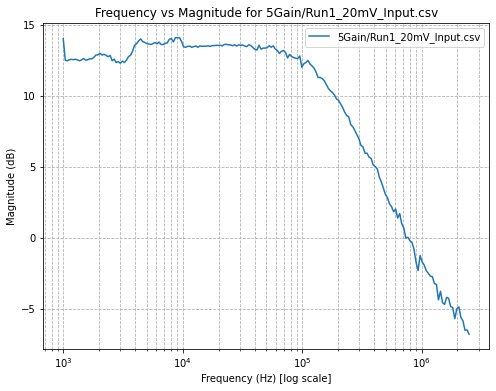

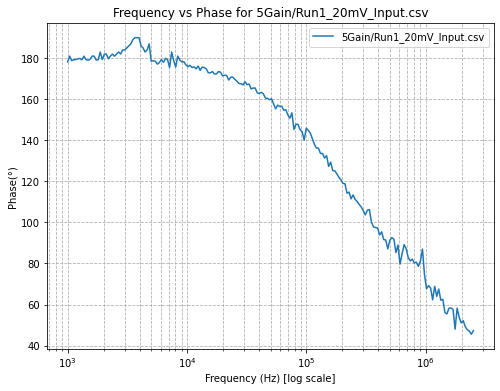

In [18]:
# Pick dataset
source_folder_to_plot = '5Gain'  # Replace with folder name
source_file_to_plot = 'Run1_20mV_Input.csv'  # Replace with file name

# Call the plot functions for the specific folder and file
plot_frequency_vs_magnitude(combined_df, source_folder_to_plot, source_file_to_plot)
plot_frequency_vs_phase(combined_df, source_folder_to_plot, source_file_to_plot)